# Temperature Analysis II

In [1]:
#import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables Into SQLAlchemy ORM

In [2]:
#create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
#reflect hawaii database
Base = automap_base()
Base.prepare(engine, reflect=True)

#view classes
Base.classes.keys()

['measurement', 'station']

In [4]:
#save reference to measurement class
Measurement = Base.classes.measurement

#save reference to station class
Station = Base.classes.station

In [5]:
#create session
session = Session(engine)

In [6]:
#calc_temps function provided by given materials
#start_date (string): A date string in the format %Y-%m-%d
#end_date (string): A date string in the format %Y-%m-%d 
#Returns: TMIN, TAVG, and TMAX

def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [7]:
#find data for Aug. 1 - Aug. 7 from a previous year
aug_2015_data = calc_temps('2015-08-01', '2015-08-07')
aug_2015_data

[(69.0, 78.27272727272727, 85.0)]

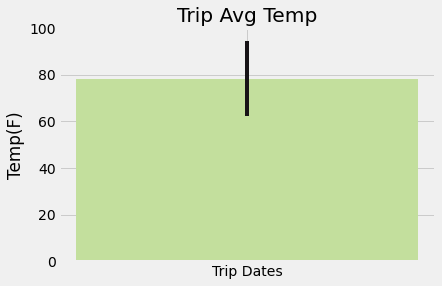

<Figure size 144x432 with 0 Axes>

In [8]:
#plot the aug_2015_data
aug_min = aug_2015_data[0][0]
aug_avg = aug_2015_data[0][1]
aug_max = aug_2015_data[0][2]
aug_ptp = aug_max - aug_min

plt.bar(1, aug_avg, width=0.2, color='#C3DF9D')
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
plt.xticks([1], labels=['Trip Dates'])
plt.ylim(0, 100)
plt.errorbar(1, aug_avg, yerr=aug_ptp, fmt='-', color='#171317')
plt.figure(figsize=(2, 6)) 

plt.show()

# Daily Rainfall Average

In [9]:
#total rainfall per station
total_prcp = session.query(func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
            select_from(Measurement).\
            join(Station, Measurement.station == Station.station).\
            group_by(Station.name).\
            order_by(func.sum(Measurement.prcp).desc()).all()
total_prcp

[(1068.0899999999956,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (588.6399999999976,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (382.61999999999847, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (295.67999999999944,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (234.49000000000026,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (131.62000000000063, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (92.68000000000006,
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9),
 (70.87000000000005, 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (43.44000000000002, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [10]:
#daily normals function provided by given materials
#date (str): A date string in the format '%m-%d'
#Returns: A list of tuples containing the daily normals, tmin, tavg, and tmax

def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [11]:
#start and end date of the trip
start_date = dt.date(2017, 8, 1)
end_date = dt.date(2017, 8, 7)

In [12]:
#date_range function from user bvdet(https://bytes.com/topic/python/answers/774887-how-create-list-dates-between-two-dates)
def date_range(start, end):
    r = (end + dt.timedelta(days=1) - start).days
    return [start + dt.timedelta(days=i) for i in range(r)]

trip_range = date_range(start_date, end_date)

In [13]:
#pull the month and day out for each date
trip_range_dates = []

for date in trip_range:
    month = date.strftime('%m')
    day = date.strftime('%d')
    new_date = f'{month}-{day}'
    trip_range_dates.append(new_date)
    
trip_range_dates

['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

In [14]:
#run daily_normal function on each date in trip_range_dates
normals = [daily_normals(date) for date in trip_range_dates]

normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [15]:
#create a dataframe of the previous data
normals_df = pd.DataFrame(normals, columns=['Normals'], index=(trip_range))

normals_df

,Normals
2017-08-01,"(67.0, 75.54, 83.0)"
2017-08-02,"(68.0, 75.60377358490567, 84.0)"
2017-08-03,"(70.0, 76.61111111111111, 85.0)"
2017-08-04,"(69.0, 76.71153846153847, 84.0)"
2017-08-05,"(69.0, 76.14814814814815, 82.0)"
2017-08-06,"(67.0, 76.25, 83.0)"
2017-08-07,"(71.0, 77.15686274509804, 83.0)"


In [16]:
#splitting the normals column
min_temp = []
avg_temp = []
max_temp = []

for index, row in normals_df.iterrows():
    min_temp.append(row[0][0])
    avg_temp.append(row[0][1])
    max_temp.append(row[0][2])


In [17]:
#creating the new columns in the df
normals_df['Min Temp'] = min_temp
normals_df['Avg Temp'] = avg_temp
normals_df['Max Temp'] = max_temp

normals_df

,Normals,Min Temp,Avg Temp,Max Temp
2017-08-01,"(67.0, 75.54, 83.0)",67.0,75.540000,83.0
2017-08-02,"(68.0, 75.60377358490567, 84.0)",68.0,75.603774,84.0
2017-08-03,"(70.0, 76.61111111111111, 85.0)",70.0,76.611111,85.0
2017-08-04,"(69.0, 76.71153846153847, 84.0)",69.0,76.711538,84.0
2017-08-05,"(69.0, 76.14814814814815, 82.0)",69.0,76.148148,82.0
2017-08-06,"(67.0, 76.25, 83.0)",67.0,76.250000,83.0
2017-08-07,"(71.0, 77.15686274509804, 83.0)",71.0,77.156863,83.0


In [18]:
#dropping normals column
normals_df.drop(columns=['Normals'], inplace=True)

In [19]:
normals_df

,Min Temp,Avg Temp,Max Temp
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


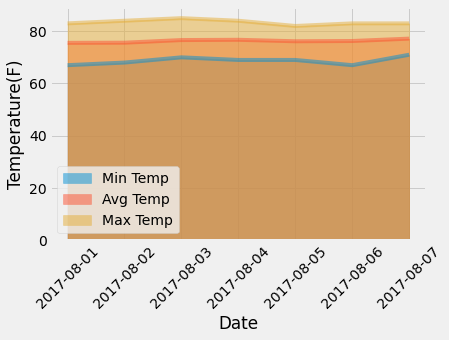

In [20]:
#creating area plot
normals_df.plot.area(stacked=False)

plt.xticks(rotation=45)
plt.ylabel('Temperature(F)')
plt.xlabel('Date')

plt.show()

# Close Session

In [21]:
# Close Session
session.close()